In [1]:
!git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
!unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
path="/content/BasicsMusicalInstrumClassifi"

'git' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn 
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC
import joblib
from sklearn.preprocessing import LabelEncoder
# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa



In [4]:
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 600 audio files in /content/BasicsMusicalInstrumClassifi


In [5]:
# Get Labels
labels =[]

classes=['flute','sax','oboe', 'cello','trumpet','viola']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')
print(labels)


['viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'viola', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 'cello', 

In [6]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)
l = []
for i in labelencoder.classes_:
    l.append(i)

6 classes: cello, flute, oboe, sax, trumpet, viola


In [7]:
fs = 44100         # Sampling Frequency(frequency sample)
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands, fixed length of 128
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier(odd number)

In [8]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

In [9]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 600 = /content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs5_15_pianissimo_arco-normal.mp3
get 2 of 600 = /content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs5_05_forte_arco-normal.mp3
get 3 of 600 = /content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs4_05_piano_arco-normal.mp3
get 4 of 600 = /content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs6_05_piano_arco-normal.mp3
get 5 of 600 = /content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_A3_05_mezzo-piano_arco-normal.mp3
get 6 of 600 = /content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs6_1_pianissimo_arco-normal.mp3
get 7 of 600 = /content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_A3_05_piano_arco-normal.mp3
get 8 of 600 = /content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_

In [10]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (600, 13)


In [11]:
filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
#with open(filename, "rb") as f:
#    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

# Save feature_vectors for future use
with open(filename, "wb") as f:
    pickle.dump( scaled_feature_vectors, f)

In [12]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [13]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


In [14]:
svclassifier = SVC(kernel='rbf', C = 10.0, gamma=0.1)

In [15]:
svclassifier.fit(train_set, train_classes);

In [16]:
# Save
joblib.dump(svclassifier, 'trainedSVM.joblib')
#Load
#svclassifier = joblib.load('filename.joblib')

['trainedSVM.joblib']

In [17]:
predicted_labels = svclassifier.predict(test_set)
print(predicted_labels)

[5 4 4 3 5 2 2 3 1 2 0 1 0 5 4 2 5 0 0 0 0 1 4 3 4 1 3 5 5 2 5 5 4 1 5 5 2
 1 2 1 3 1 2 4 2 2 5 2 0 0 4 0 0 3 5 3 0 1 1 0 3 3 5 2 1 4 3 3 1 1 5 5 5 5
 1 2 4 0 5 1 4 0 1 2 1 5 4 3 3 1 2 4 0 4 1 3 3 3 4 4 3 1 2 4 0 0 3 0 0 3 4
 2 4 5 1 2 1 4 5 0 2 4 3 4 4 3 2 5 5 5 0 2 3 4 0 2 0 5 3 1 2 2 3 4 2 1 5 1
 0 0]


In [18]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.96 1.   1.   0.96 1.   0.96]
Precision:  [0.96       1.         1.         1.         1.         0.92307692]
F1-Score:  [0.96       1.         1.         0.97959184 1.         0.94117647]
Accuracy: 0.98  , 147
Number of samples: 150


In [19]:
print(classification_report(test_classes, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      0.96      0.98        25
           4       1.00      1.00      1.00        25
           5       0.92      0.96      0.94        25

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



In [20]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [21]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

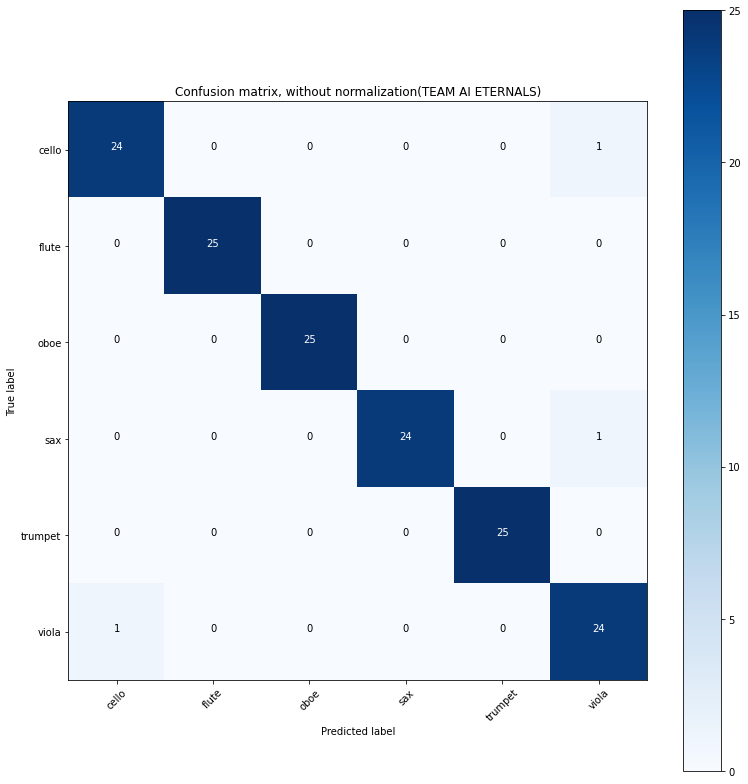

In [22]:
# Plot non-normalized confusion matrix(values)
plt.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization(TEAM AI ETERNALS)')

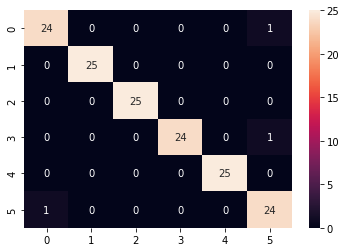

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_classes, predicted_labels)
f = sns.heatmap(cm, annot=True, fmt='d')

In [24]:

# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [25]:
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print(np.array(files)[test_index[wrong_predictions]])
print(wrong_predictions)

['cello' 'viola' 'sax']
[5 0 5]
['viola' 'cello' 'viola']
['/content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/cello/cello_Gs5_1_mezzo-forte_arco-harmonic.mp3'
 '/content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/viola/viola_Gs4_025_fortissimo_arco-normal.mp3'
 '/content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_pianissimo_normal.mp3']
[46, 105, 113]


In [26]:
filename = "/content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_A3_15_pianissimo_normal.mp3"
for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            print(name)
            print(filename)
            print(l.index(name))
            


trumpet
/content/BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/trumpet/trumpet_A3_15_pianissimo_normal.mp3
4
